<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

Code based on https://github.com/pytorch/examples/blob/master/mnist/main.py

In this exercise we are using high level abstractions from torch.nn like nn.Linear.
Note: during the next lab session we will go one level deeper and implement more things
with bare hands.

Tasks:

    1. Read the code.

    2. Check that the given implementation reaches 95% test accuracy for architecture input-128-128-10 after few epochs.

    3. Add the option to use SGD with momentum instead of ADAM.

    4. Experiment with different learning rates, plot the learning curves for different
    learning rates for both ADAM and SGD with momentum.

    5. Parameterize the constructor by a list of sizes of hidden layers of the MLP.
    Note that this requires creating a list of layers as an atribute of the Net class,
    and one can't use a standard python list containing nn.Modules (why?).
    Check torch.nn.ModuleList.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Net(nn.Module):
    def __init__(self, layers=[784, 128, 128, 10]):
        super(Net, self).__init__()
        # After flattening an image of size 28x28 we have 784 inputs
        self.layers = nn.ModuleList([nn.Linear(a, b) for a, b in zip(layers[:-1], layers[1:])])

    def forward(self, x):
        x = torch.flatten(x, 1)
        for l in self.layers[:-1]:
          x = l(x)
          x = F.relu(x)
        x = self.layers[-1](x)
        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer, epoch, log_interval, silent=False):
    model.train()
    logs = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            if not silent:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            logs.append(loss.item())
    return logs



def test(model, device, test_loader, silent=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    if not silent:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)



In [ ]:
batch_size = 256
test_batch_size = 1000
epochs = 5
lr = 1e-2
use_cuda = False
seed = 1
log_interval = 10

In [ ]:
use_cuda = not use_cuda and torch.cuda.is_available()

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
params = [
    ("adam", 1e-2),
    ("adam", 1e-3),
    ("adam", 1e-4),
    ("momentum", 1e-2),
    ("momentum", 1e-3),
    ("momentum", 1e-4),
]
results = []
for p in params:
    model = Net().to(device)
    if p[0] == "adam":
        optimizer = optim.Adam(model.parameters(), lr=p[1])
    if p[0] == "momentum":
        optimizer = optim.SGD(model.parameters(), lr=p[1], momentum=0.9)

    train_history = []
    acc_history = []
    for epoch in range(1, epochs + 1):
        train_history.extend(train(model, device, train_loader, optimizer, epoch, log_interval, silent=True))
        acc_history.append(test(model, device, test_loader, silent=True))
    results.append((train_history, acc_history))

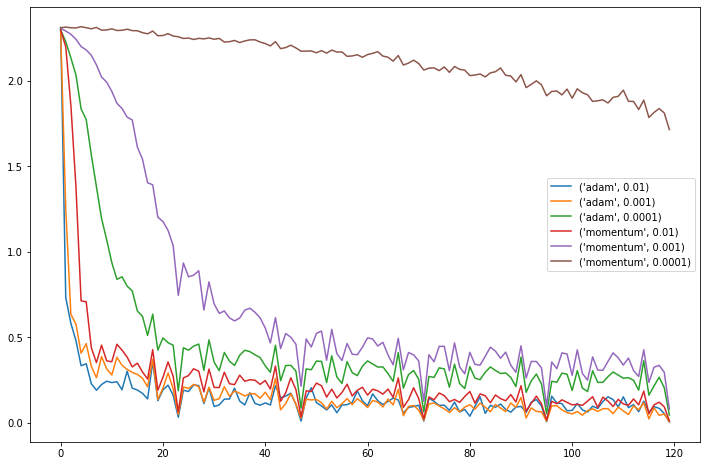

In [ ]:
plt.figure(figsize=(12,8))
for r, p in zip(results, params):
    plt.plot(r[0], label=str(p))
plt.legend()